In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pickle
sys.path.append("../../../ukb-dementia-shap/")

def prep_data(df,eids_in,eids_inc_depvar,eids_exc_depvar,depvar):
    mask=(df['eid'].isin(eids_in))&~(df['eid'].isin(eids_exc_depvar))
    df_out=df.loc[mask,]

    df_out[depvar]=0
    df_out.loc[df_out['eid'].isin(eids_inc_depvar),depvar]=1
    
    return df_out

race_dict=dict({'British':'White',
 'Any other white background':'White',
 'Other ethnic group':'Others',
 'Irish':'White',
 'White':'White',
 'Prefer not to answer':'Others',
 'Any other mixed background':'Mixed',
 'African':'Black',
 'Indian':'South Asian',
 'White and Asian':'Mixed',
 'Pakistani':'South Asian',
 'Caribbean':'Black',
 'Chinese':'Chinese',
 'Any other Asian background':'South Asian',
 'White and Black African':'Mixed',
 'White and Black Caribbean':'Mixed',
 'Black or Black British':'Black',
 'Do not know':'Others',
 'Bangladeshi':'South Asian',
 'Any other Black background':'Black',
 'Mixed':'Mixed',
 'Asian or Asian British':'South Asian'})


drops=['date_of_attending_assessment_centre_f53_0_0','AD','dementia']
from logic.data_processing.data_setup import *
from logic.analysis.analysis import AnalysisCharts
from pandas.tseries.offsets import DateOffset

ds=data_setup()
an=AnalysisCharts()
dp=data_proc_main()

ml.path_figures='../figures/'

In [2]:
df_dis_date_test2=pd.read_parquet(dp.path+'df_dis_date_test2.parquet')
df_model=pd.read_parquet(dp.path+'df_all_final2022-04-13.parquet')
df_model=dp.studyvars_add(df_model)
ad=ds.return_eids(df_dis_date_test2,string='G30',icd10s=True,string_exc='xxxxx',years=2)

df_ad=prep_data(df=df_model,eids_in=list(df_model['eid']),
                eids_inc_depvar=ad['eids_inc_pro'],eids_exc_depvar=ad['eids_exc_pro']+ad['ctrl_deaths'],
                depvar='AD')

AD_full_eids=list(ad['cases']['eid'])
df_ad_full=prep_data(df=df_model,eids_in=list(df_model['eid']),
                eids_inc_depvar=AD_full_eids,eids_exc_depvar=ad['ctrl_deaths'],
                depvar='AD')

In [3]:

mask=(df_ad['age_when_attended_assessment_centre_f21003_0_0']<=80)\
&(df_ad['age_when_attended_assessment_centre_f21003_0_0']>=50)
df_ad=df_ad.loc[mask,]

mask=(df_ad_full['age_when_attended_assessment_centre_f21003_0_0']<=80)\
&(df_ad_full['age_when_attended_assessment_centre_f21003_0_0']>=50)

df_ad_full=df_ad_full.loc[mask,]

df_ad_full=pd.merge(df_ad_full,ad['cases'][['eid','disease_date','date_assess']],on='eid',how='left')
df_ad_full['years_AD']=-round((df_ad_full['disease_date']-df_ad_full['date_assess']).dt.days/365)

In [ ]:
df_ad['phys_yn']=df_ad['number_of_daysweek_of_vigorous_physical_activity_10_minutes_f904_0_0'].\
apply(lambda x:1 if x>0 else 0)



In [11]:
dp.findcols(df_ad,'met_min')

['met_minutes_per_week_for_walking_f22037_0_0',
 'met_minutes_per_week_for_moderate_activity_f22038_0_0',
 'met_minutes_per_week_for_vigorous_activity_f22039_0_0',
 'summed_met_minutes_per_week_for_all_activity_f22040_0_0',
 'met_min']

<AxesSubplot:>

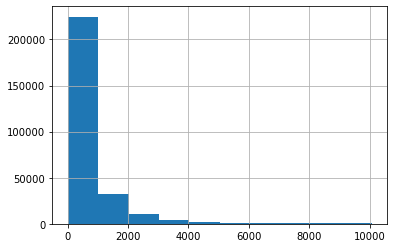

In [13]:
df_ad['met_minutes_per_week_for_vigorous_activity_f22039_0_0'].hist()

In [14]:
df_ad['met_min_walk']=pd.qcut(df_ad['met_minutes_per_week_for_walking_f22037_0_0'],5,labels=False)
df_ad['met_min_mod']=pd.qcut(df_ad['met_minutes_per_week_for_moderate_activity_f22038_0_0'],5,labels=False)
#df_ad['met_min_vig']=pd.qcut(df_ad['met_minutes_per_week_for_vigorous_activity_f22039_0_0'],5,labels=False)
df_ad['met_min_all']=pd.qcut(df_ad['summed_met_minutes_per_week_for_all_activity_f22040_0_0'],5,labels=False)


In [18]:
df_ad.groupby('met_min_walk')['AD'].mean()

met_min_walk
0.0    0.006950
1.0    0.006804
2.0    0.008032
3.0    0.008413
4.0    0.008469
Name: AD, dtype: float64

In [9]:
df_train,df_val=ml.holdout_data(df_ad,agemin=50,agemax=70,depvar='AD',apoe=2,holdout_ratio=0.3,apoe_filt=True)

Total AD in data: 2355


In [10]:
df_train.to_parquet('../data/AD_train_20220524.parquet')
df_val.to_parquet('../data/AD_holdout_20220524.parquet')
df_ad.to_parquet('../data/df_ad_20220524.parquet')
df_ad_full.to_parquet('../data/df_ad_full_20220524.parquet')

#### Population Characteristics

In [11]:
df_ad_pop=pd.merge(df_ad,ad['cases'][['eid','disease_date','date_assess']],on='eid',how='left')
df_ad_pop['years_PD']=round((df_ad_pop['disease_date']-df_ad_pop['date_assess']).dt.days/365)
df_ad_pop['Age_PD']=df_ad_pop['age_when_attended_assessment_centre_f21003_0_0']+df_ad_pop['years_PD']

In [12]:
df_eth=pd.read_parquet('../../data/df_eth.parquet')
df_eth['eid']=df_eth['eid'].astype(str)

In [13]:
df_pd_pop=pd.merge(df_pd_pop,df_eth,on='eid',how='left')

NameError: name 'df_pd_pop' is not defined

In [35]:
df_pd_pop['Ethnicity']='Others'
df_pd_pop.loc[pd.notnull(df_pd_pop['ethnic_background_f21000_0_0']),'Ethnicity']=\
df_pd_pop['ethnic_background_f21000_0_0'].map(race_dict)

In [31]:
dp.findcols(df_pd_pop,'age_when')

['age_when_attended_assessment_centre_f21003_0_0']

In [27]:
df_pd_pop['Ethnicity'].value_counts()

White          321471
South Asian      5310
Others           4094
Black            3735
Mixed            1338
Chinese           833
Name: Ethnicity, dtype: int64

In [38]:
df_pd_pop.groupby(['sex_f31_0_0','PD']).agg({'Age_PD':['mean','std'],'years_PD':['mean','std'],'PD':'count'})

Age_PD            years_PD                PD
                     mean       std      mean       std   count
sex_f31_0_0 PD                                                 
0.0         0         NaN       NaN       NaN       NaN  148283
            1   71.651943  5.155753  8.100707  2.816504    1698
1.0         0         NaN       NaN       NaN       NaN  185779
            1   71.215475  5.217485  7.955926  2.914638    1021

In [1]:
df_pd_pop.groupby(['Ethnicity','PD','sex_f31_0_0']).agg({'PD':'count'}).unstack('PD').reset_index()

NameError: name 'df_pd_pop' is not defined

In [22]:
mask=(df_pd_full['disease_date']<df_pd_full['date_assess'])

df_pd_full.loc[mask,['disease_date','date_assess','years_PD']].sample(20)

,disease_date,date_assess,years_PD
182813,2004-05-14,2009-01-05,5.0
270212,2003-05-11,2006-05-24,3.0
318103,2005-05-20,2010-03-12,5.0
54520,2006-09-22,2008-09-01,2.0
49790,2007-05-03,2008-10-30,1.0
233042,2003-02-26,2008-04-30,5.0
101324,2006-12-25,2008-10-03,2.0
74457,2008-02-08,2009-07-14,1.0
18511,2007-07-02,2008-05-14,1.0
177647,2002-05-31,2008-01-10,6.0


In [1]:
df_pd_full

NameError: name 'df_pd_full' is not defined